In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
%matplotlib inline
import pandas as pd

In [42]:
voltage = 400 #nominal_voltage
battery_volumn = 60 * 1000 / 400 # Q = kWh / v
emission_max_value = 100
start_soc = 0.216
end_soc = 0.7
target_charge_volumn = (end_soc - start_soc) *battery_volumn
Power = 10 * 1000 # power of the charger
I_max = Power  / voltage
R = 10 # resistance
Power_limit = 100 * 1000 # simple assumption to the limit of the power: 100 kw
Power_limit_slope_line_Intercept = 100 * 1000 # simple assumption to the limit of the power(the sloped line): 100 kw

In [43]:
step = 1/6 # 10(min)/ 60(min)

In [44]:
maximum_steps = 24 / step # 24 hours divided by step

In [45]:
x = np.linspace(0, int(maximum_steps), int(maximum_steps+1))
emission_array = emission_max_value/((maximum_steps/2)**2) * (x-(maximum_steps/2))**2

In [46]:
current_state = cp.Variable(int(maximum_steps+1),'current at each step')
P = cp.Variable(int(maximum_steps+1),'power of the charger at each step')
soc = cp.Variable(int(maximum_steps+1),"state of charge")
voltage = cp.Variable(int(maximum_steps+1),"voltage")


objective = cp.Minimize( cp.sum(P*emission_array))
constraints = []

# constraint on voltage
for i in range(0,int(maximum_steps+1)):
    constraints += [voltage[i] == 400]

# constraint on the relationship between I and P
for i in range(0,int(maximum_steps+1)):
    constraints += [P[i] == 2*R*current_state[i] + 400 * current_state[i]]

constraints += [soc[0] == start_soc]

# SOC update formula
for i in range(1,int(maximum_steps+1)):
    constraints += [soc[i] == soc[i-1] +current_state[i-1]*step/ battery_volumn]

# Second part of power limit (inclined line)
for i in range(0,int(maximum_steps+1)):
    constraints += [P[i] <= Power_limit_slope_line_Intercept*(1- soc[i])] 
# first part of power limit (straight line)
for i in range(0,int(maximum_steps+1)):
    constraints += [P[i] <= Power_limit] 

constraints += [ cp.sum(current_state)*step >= (target_charge_volumn)]
constraints += [P <= Power]
constraints += [P >= 0]

problem = cp.Problem(objective, constraints)
result = problem.solve()
print(result)
P_values = P.value
P_values = [value if value>=1 else 0 for value in P_values ]
print(P_values)

/home/yihua/anaconda3/lib/python3.10/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 6 times so far.

  warnings.warn(msg, UserWarning)


86689.95370840293
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2306.2813286758173, 9999.999999854428, 9999.999999855578, 9999.999999896429, 9999.99999991749, 9999.999999930169, 9999.999999938454, 9999.999999943773, 9999.99999994682, 9999.999999947944, 9999.999999947253, 9999.999999944634, 9999.999999939702, 9999.99999993165, 9999.999999918866, 9999.999999897927, 9999.999999863281, 9999.999999890566, 2804.9186711948923, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [49]:
I_values = [(-400 + np.sqrt(400*400 + 8*R*P))/(4*R) for P in P_values]
print(I_values)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.608430839293831, 22.47448713886176, 22.474487138864106, 22.47448713894748, 22.474487138990483, 22.47448713901636, 22.474487139033272, 22.47448713904413, 22.474487139050353, 22.47448713905264, 22.474487139051234, 22.47448713904589, 22.47448713903583, 22.474487139019388, 22.474487138993297, 22.47448713895055, 22.474487138879823, 22.47448713893553, 6.78229879337421, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


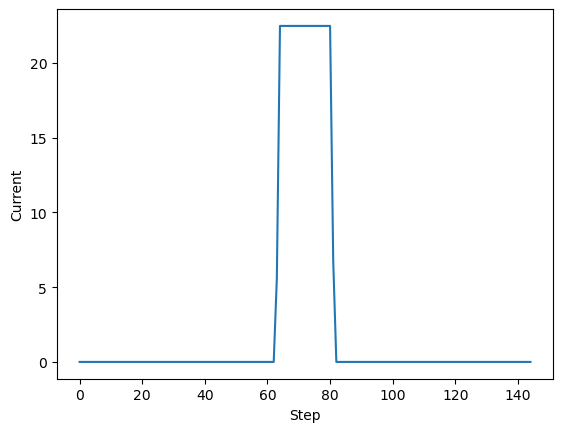

In [51]:
x = np.array([i for i in range(len(P_values))])
plt.figure()
plt.plot(x, I_values)
plt.xlabel("Step")
plt.ylabel("Current")

plt.show()